# Tutorial 4: Hybrid Modeling (Contd.)

## Objectives

After this tutorial you will be able to:

*   Understand the advantages and limiatations of the different architectures of hybrid models. 
*   Build and apply different hybrid model architectures on real-world applications.


<h2>Table of Contents</h2>

<ol>
    <li>
        <a href="#1">Parallel Architecture</a>
    </li>
    <br>
    <li>
        <a href="#2">Serial Architecture</a>
    </li>
    <br>
</ol>


<hr id="1">
<h2>1. Parallel Architecture</h2>


Consider the following system of consecutive first-order reactions:

<div style="text-align: center; margin:2rem;">
    <img src="r1.png">
</div>

The rate equations for the 3 components are as follows:

<div style="text-align: center; margin:2rem;">
    <img src="r2.png">
</div>

The typical concentration profiles for this system of reactions are shown below:

<div style="text-align: center; margin:2rem;">
    <img src="r3.png">
</div>


### Objective
Data was collected from the plant and provided below. It is observed that the data doesn't exactly follow the first-principle model.  
It is required to model the actual concentration profile of component **R** given the above relations and the plant data.  
To this aim, a parallel hybrid model will be used where the blackbox model compensates for the estimation error of the whitebox model.

<div style="text-align: center; margin:2rem;">
    <img src="parallel.png">
</div>

## 1. Define the system parameters and exact solution (for model evaluation)

#### Import necessary Libraries

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

#### Define system parameters

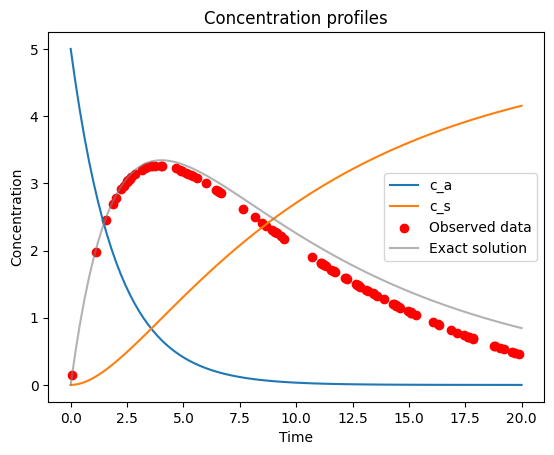

In [2]:
# System model
def calc_s_a(c_a0, k1, k2, t):
    c_a = c_a0 * torch.exp(-k1 * t)
    return c_a

def calc_c_r(c_a0, k1, k2, t):
    c_r = c_a0 * k1 * (torch.exp(-k1 * t) - torch.exp(-k2 * t)) / (k2 - k1)
    return c_r

def calc_s_c(c_a0, k1, k2, t):
    c_a = calc_s_a(c_a0, k1, k2, t)
    c_r = calc_c_r(c_a0, k1, k2, t)
    c_s = c_a0 - c_a - c_r
    return c_s


# synthesize observed data with error
torch.manual_seed(12)
c_a0 = 5
k1 = 0.5
k2 = 0.1
t_obs = torch.rand(100).view(-1, 1) * 20
t_obs = torch.sort(t_obs, dim=0).values
y_obs = calc_c_r(c_a0, k1, k2, t_obs) - 0.02*t_obs

t_test = torch.linspace(0, 20, 100).view(-1, 1)
y_exact = calc_c_r(c_a0, k1, k2, t_test)

# plot the data
def plot_observed_data():
    plt.scatter(t_obs, y_obs, label='Observed data', color='red')
    plt.plot(t_test, y_exact, label='Exact solution', color='grey', alpha=0.6)
    plt.legend()
    plt.show()


# plot c_a & c_s profiles
plt.plot(t_test, calc_s_a(c_a0, k1, k2, t_test), label='c_a')
plt.plot(t_test, calc_s_c(c_a0, k1, k2, t_test), label='c_s')
plt.title('Concentration profiles')
plt.xlabel('Time')
plt.ylabel('Concentration')

# plot c_r profile with observations
plot_observed_data()

## 2. Model

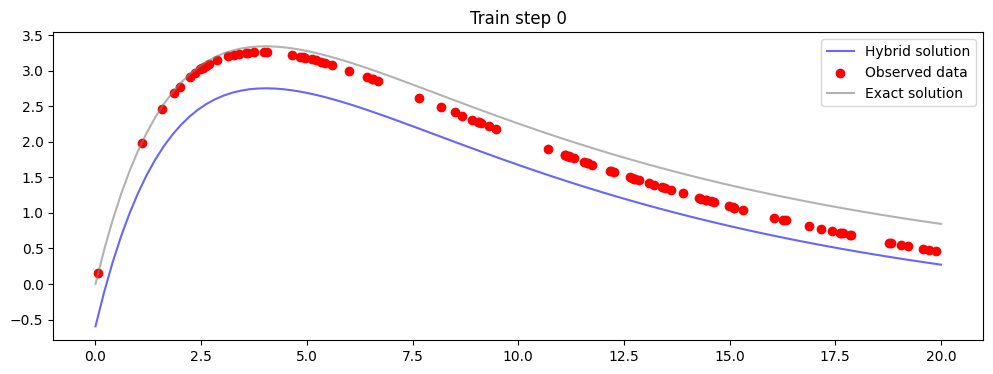

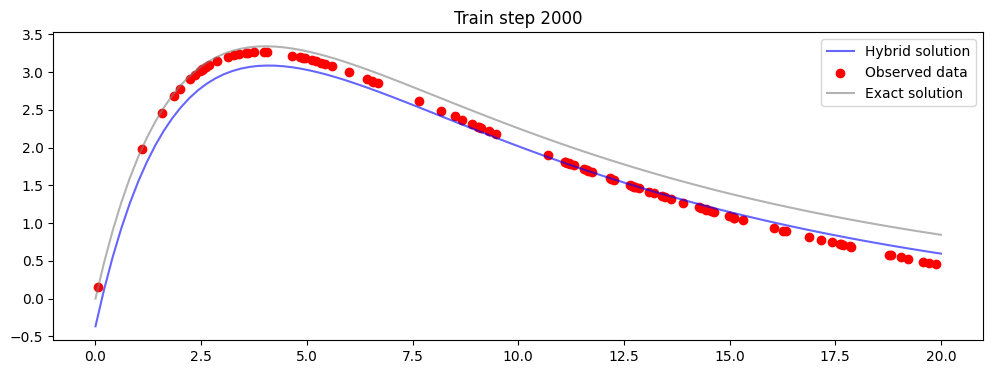

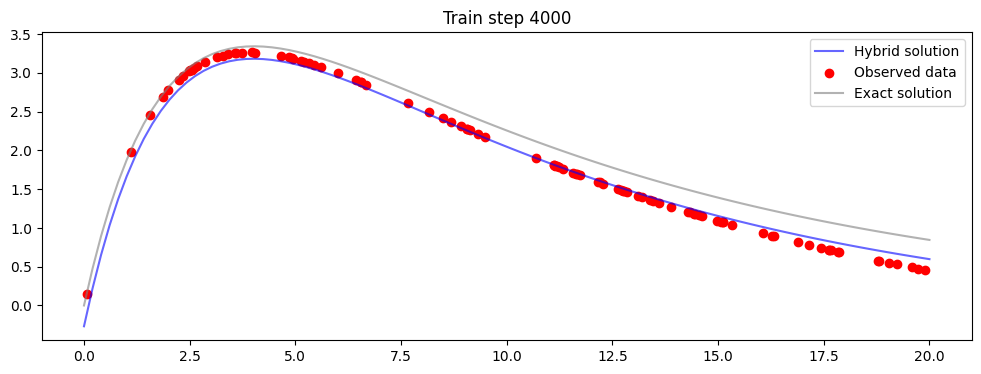

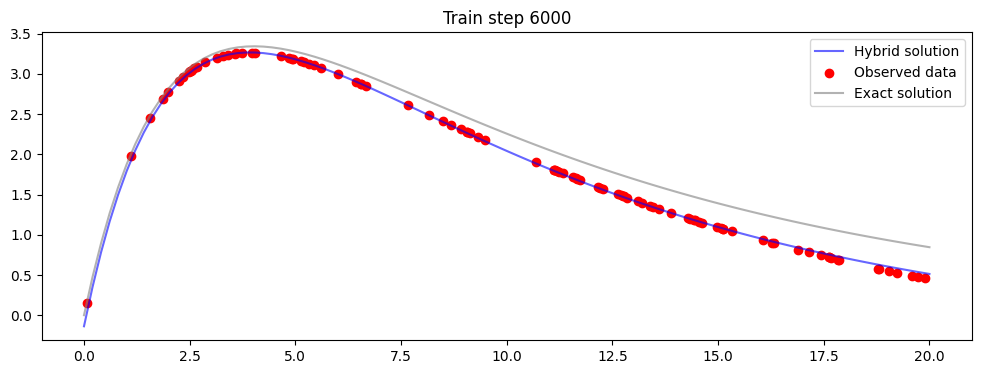

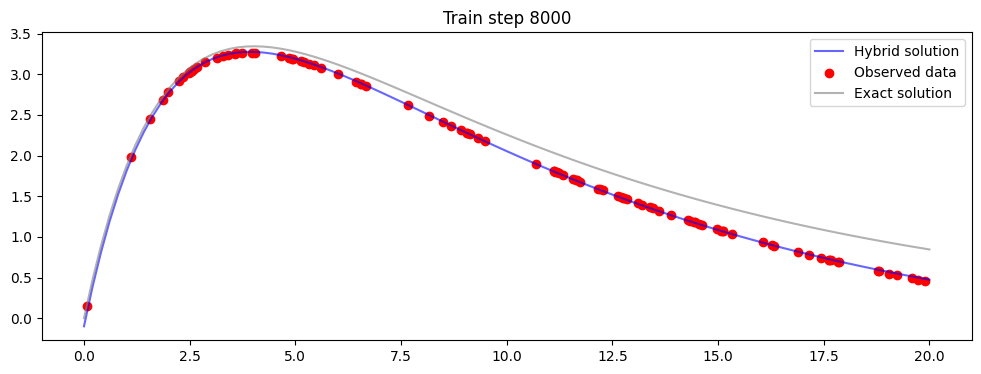

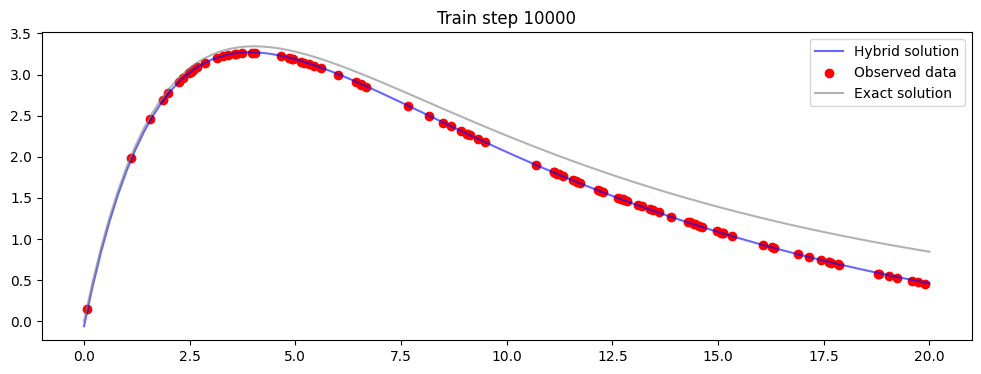

In [3]:
# create neural network class
class NN(nn.Module):
    # define the class constructor
    def __init__(self, n_input, n_output, n_hidden, n_layers, act_fn=nn.Tanh()):
        # initialize the super/parent class (nn.Module)
        super().__init__()

        # assign the activation function
        self.act_fn = act_fn

        # create the first hidden layer connected to the inputs
        self.nn_start = nn.Sequential(nn.Linear(n_input, n_hidden), act_fn)

        # create the rest of the hidden layers
        self.nn_hidden = nn.Sequential(*[nn.Sequential(nn.Linear(n_hidden, n_hidden), act_fn) for _ in range(n_layers-1)])

        # create the output layer
        self.nn_end = nn.Linear(n_hidden, n_output)

    # define the forward pass of the network
    def forward(self, x):
        x = self.nn_start(x)
        x = self.nn_hidden(x)
        x = self.nn_end(x)
        return x

    # define the fit method
    def fit(self, X, y, n_epochs, lr=0.01):
        # optimizer and loss function
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        loss_fn = nn.MSELoss()

        # train the model
        for epoch in range(n_epochs + 1):
            # 1. reset the gradients back to zero
            optimizer.zero_grad()

            # 2. compute the output
            y_pred = self(X)

            # 3. compute data loss
            loss = loss_fn(y_pred, y)

            # 4. backpropagate the loss
            loss.backward()

            # 5. update the weights
            optimizer.step()

            # plot the result as training progresses
            if epoch % 2000 == 0:
                y_pred = self.forward(t_test).detach()
                y_phys = calc_c_r(c_a0, k1, k2, t_test)
                plt.figure(figsize=(12, 4))
                plt.title(f'Train step {epoch}')
                plt.plot(t_test[:,0], y_phys[:, 0] + y_pred[:,0], label='Hybrid solution', color='blue', alpha=0.6)
                plot_observed_data()

# create a neural network instance
model_parallel = NN(1, 1, 2, 2)

# solve the physical model relation
y_phys = calc_c_r(c_a0, k1, k2, t_obs)

# calculate the expectation error
y_delta = y_obs - y_phys

# train the NN
model_parallel.fit(t_obs, y_delta, 10000, lr=0.0001)


<hr id="2">
<h2>2. Serial Architecture</h2>


Consider the following system of consecutive first-order reactions:

<div style="text-align: center; margin:2rem;">
    <img src="r1.png">
</div>

The rate equations for the 3 components are as follows:

<div style="text-align: center; margin:2rem;">
    <img src="r2.png">
</div>

The typical concentration profiles for this system of reactions are shown below:

<div style="text-align: center; margin:2rem;">
    <img src="r3.png">
</div>


### Objective
Data was collected from the plant and provided below. The reaction kinetic parameters are unknown.
It is required to model the concentration profile of component **R** given the above relations and the plant data.
To this aim, a serial hybrid model will be used where the blackbox model estimates the kinetic parameters **k1 & k2** and the whitebox model includes the mass balance equation.

<div style="text-align: center; margin:2rem;">
    <img src="serial.png">
</div>

## 1. Define the system parameters and exact solution (for model evaluation)

#### Define system parameters

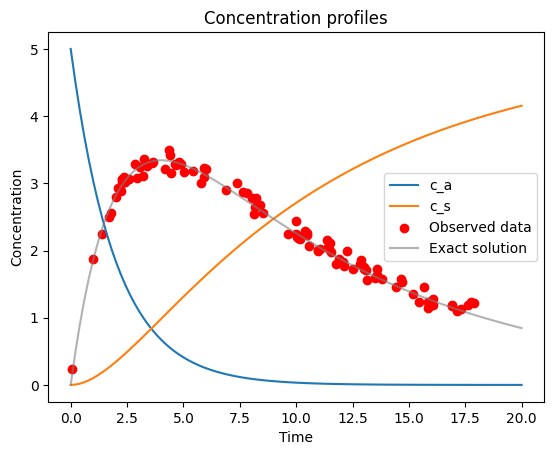

In [4]:
# System model
def calc_s_a(c_a0, k1, k2, t):
    c_a = c_a0 * torch.exp(-k1 * t)
    return c_a

def calc_c_r(c_a0, k1, k2, t):
    c_r = c_a0 * k1 * (torch.exp(-k1 * t) - torch.exp(-k2 * t)) / (k2 - k1)
    return c_r

def calc_s_c(c_a0, k1, k2, t):
    c_a = calc_s_a(c_a0, k1, k2, t)
    c_r = calc_c_r(c_a0, k1, k2, t)
    c_s = c_a0 - c_a - c_r
    return c_s


# Create noisy observations
torch.manual_seed(12)
c_a0 = 5
k1 = 0.5
k2 = 0.1
t_obs = torch.rand(100).view(-1, 1) * 18
y_obs = calc_c_r(c_a0, k1, k2, t_obs) + 0.1 *torch.randn_like(t_obs)

t_test = torch.linspace(0, 20, 100).view(-1, 1)
y_exact = calc_c_r(c_a0, k1, k2, t_test)

# plot the data
def plot_observed_data():
    plt.scatter(t_obs, y_obs, label='Observed data', color='red')
    plt.plot(t_test, y_exact, label='Exact solution', color='grey', alpha=0.6)
    plt.legend()
    plt.show()


# plot c_a & c_s profiles
plt.plot(t_test, calc_s_a(c_a0, k1, k2, t_test), label='c_a')
plt.plot(t_test, calc_s_c(c_a0, k1, k2, t_test), label='c_s')
plt.title('Concentration profiles')
plt.xlabel('Time')
plt.ylabel('Concentration')

# plot c_r profile with noisy observations
plot_observed_data()

## 2. Model

c:\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([100, 100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


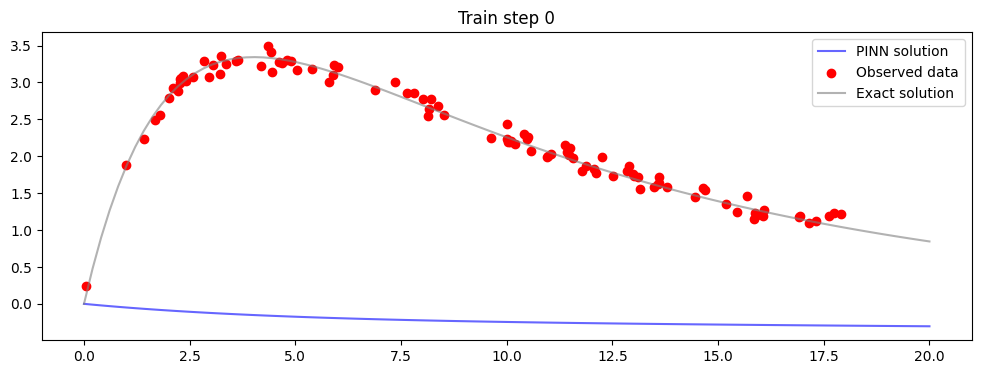

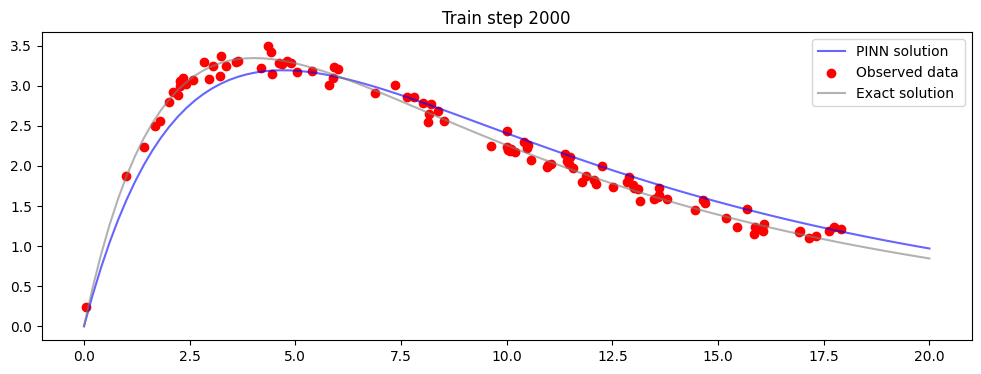

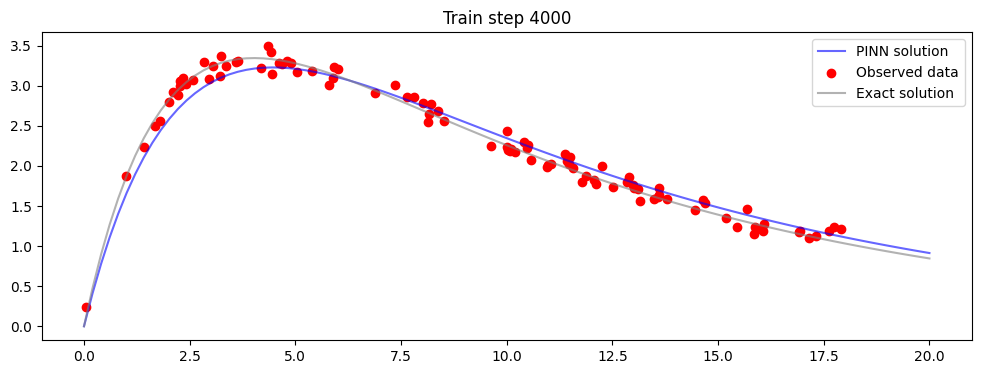

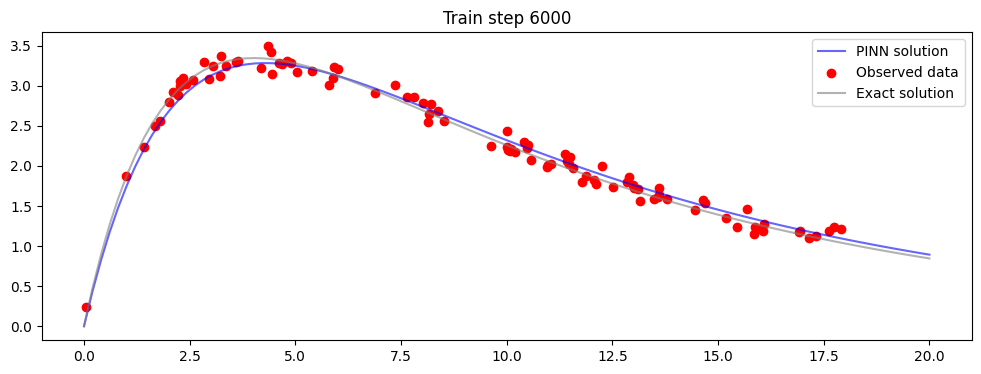

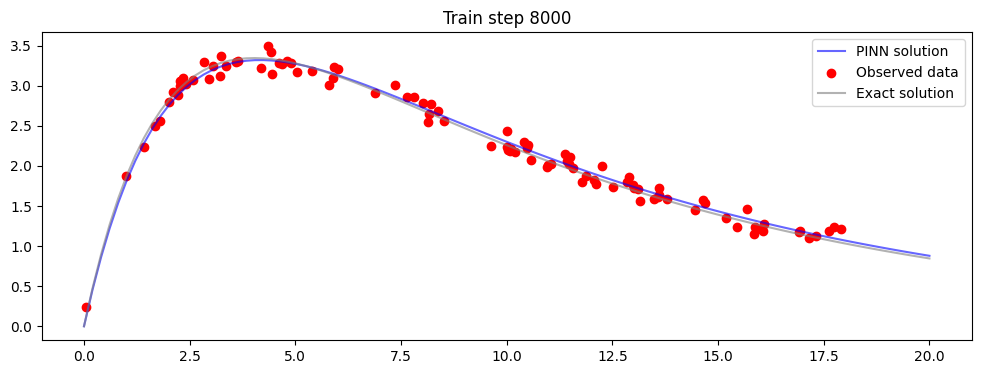

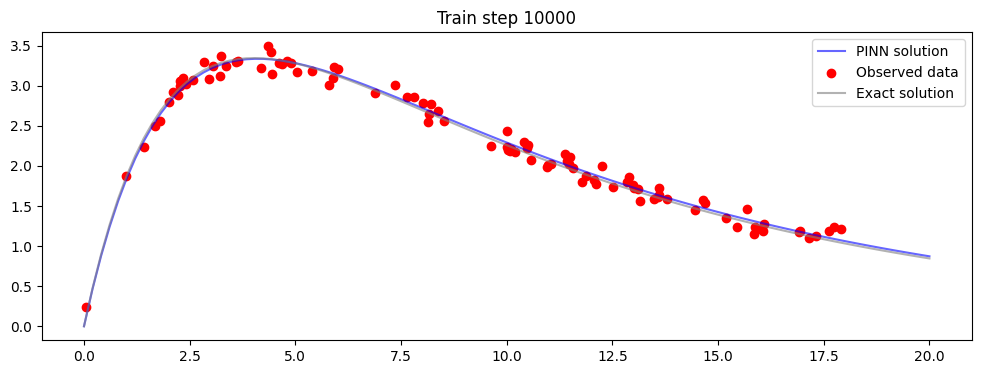

In [5]:
# create neural network class
class NN(nn.Module):
    # define the class constructor
    def __init__(self, n_input, n_output, n_hidden, n_layers, act_fn=nn.Tanh()):
        # initialize the super/parent class (nn.Module)
        super().__init__()

        # assign the activation function
        self.act_fn = act_fn

        # create the first hidden layer connected to the inputs
        self.nn_start = nn.Sequential(nn.Linear(n_input, n_hidden), act_fn)

        # create the rest of the hidden layers
        self.nn_hidden = nn.Sequential(*[nn.Sequential(nn.Linear(n_hidden, n_hidden), act_fn) for _ in range(n_layers-1)])

        # create the output layer
        self.nn_end = nn.Linear(n_hidden, n_output)

    # define the forward pass of the network
    def forward(self, x):
        x = self.nn_start(x)
        x = self.nn_hidden(x)
        x = self.nn_end(x)
        return x

    # define the fit method
    def fit(self, X, y, n_epochs, lr=0.01):
        # optimizer and loss function
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        loss_fn = nn.MSELoss()

        # train the model
        for epoch in range(n_epochs + 1):
            # 1. reset the gradients back to zero
            optimizer.zero_grad()

            # 2. compute the output
            k_pred = self(X) # [k1, k2]
            k1 = k_pred[:,0]
            k2 = k_pred[:,1]

            # 3. compute white-box model loss
            loss = loss_fn(y, calc_c_r(c_a0, k1, k2, X))

            # 4. backpropagate the loss
            loss.backward()

            # 5. update the weights
            optimizer.step()

            # plot the result as training progresses
            if epoch % 2000 == 0:
                k_pred = self.forward(t_test).detach()
                y_pred = calc_c_r(c_a0, k_pred[:,0], k_pred[:,1], t_test)
                plt.figure(figsize=(12, 4))
                plt.title(f'Train step {epoch}')
                plt.plot(t_test[:,0], y_pred[:,0], label='PINN solution', color='blue', alpha=0.6)
                plot_observed_data()

# create a neural network instance
model_serial = NN(1, 2, 3, 3)

# train the NN
model_serial.fit(t_obs, y_obs, 10000, lr=0.001)
